# getaround project

# EDA

|field name	                                  |  Comment        |
|---------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
|rental_id	                                  |  Unique identifier of the rental|
|car_id	                                      |  Unique identifier of the car |
|checkin_type	                              |  Flow used for both checkin and checkout. (ie. access and return the car) <br> mobile = rental agreement signed on the owner's smartphone <br> connect = car equiped with the Connect technology , opened by the driver with his smartphone <br> Note: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case |
|state	                                      |  canceled means that the rental did not happen (was canceled by the driver or the owner).
|delay_at_checkout_in_minutes	              |  Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
|previous_ended_rental_id	                  |  id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
|time_delta_with_previous_rental_in_minutes	  |  Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)


* Which share of our owner’s revenue would potentially be affected by the feature?
* How many rentals would be affected by the feature depending on the threshold and scope we choose?
* How often are drivers late for the next check-in? How does it impact the next driver?
* How many problematic cases will it solve depending on the chosen threshold and scope?

In [32]:
# prelude


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
k_AssetsDir     = "assets"
k_Gold          = 1.618         # gold number for ratio
k_Width         = 12
k_Height        = k_Width/k_Gold
k_WidthPx       = 1024
k_HeightPx      = k_WidthPx/k_Gold
k_random_state  = 0

In [28]:
# -----------------------------------------------------------------------------
def quick_View(df: pd.DataFrame) -> pd.DataFrame:

    """
    Generates a summary DataFrame for each column in the input DataFrame.

    This function analyzes each column in the given DataFrame and creates a summary that includes
    data type, number of null values, percentage of null values, number of non-null values, 
    number of distinct values, min and max values, outlier bounds (for numeric columns),
    and the frequency of distinct values.

    Args:
        df (pd.DataFrame): The input DataFrame to analyze.

    Returns:
        pd.DataFrame: A DataFrame containing the summary of each column from the input DataFrame. 
                      Each row in the resulting DataFrame represents a column from the input DataFrame
                      with the following information:
                      - "name": Column name
                      - "dtype": Data type of the column
                      - "# null": Number of null values
                      - "% null": Percentage of null values
                      - "# NOT null": Number of non-null values
                      - "distinct val": Number of distinct values
                      - "-3*sig": Lower bound for outliers (mean - 3*std) for numeric columns
                      - "min": Minimum value for numeric columns
                      - "max": Maximum value for numeric columns
                      - "+3*sig": Upper bound for outliers (mean + 3*std) for numeric columns
                      - "distinct val count": Dictionary of distinct value counts or top 10 values for object columns
    """

    summary_lst = []
  
    for col_name in df.columns:
        col_dtype               = df[col_name].dtype
        num_of_null             = df[col_name].isnull().sum()
        percent_of_null         = num_of_null/len(df)
        num_of_non_null         = df[col_name].notnull().sum()
        num_of_distinct_values  = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts    = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts  = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        if col_dtype != "object":
            max_of_col = df[col_name].max()
            min_of_col = df[col_name].min()
            outlier_hi = df[col_name].mean() + 3*df[col_name].std()
            outlier_lo = df[col_name].mean() - 3*df[col_name].std()
        else:
            max_of_col = -1
            min_of_col =  1
            outlier_hi = -1
            outlier_lo =  1

        summary_lst.append({
            "name"                : col_name,
            "dtype"               : col_dtype,
            "# null"              : num_of_null,
            "% null"              : (100*percent_of_null).round(2),
            "# NOT null"          : num_of_non_null,
            "distinct val"        : num_of_distinct_values,
            "-3*sig"              : round(outlier_lo,2) ,
            "min"                 : round(min_of_col,2),
            "max"                 : round(max_of_col,2),
            "+3*sig"              : round(outlier_hi,2) ,
            "distinct val count"  : distinct_values_counts
        })

    df_tmp = pd.DataFrame(summary_lst)
    return df_tmp

In [29]:
# -----------------------------------------------------------------------------
def remove_Outliers_Sigma(df, column):
    mean_col = df[column].mean()
    sigma_col = df[column].std()

    lower_bound = mean_col - 3 * sigma_col
    upper_bound = mean_col + 3 * sigma_col
    df = df[((df[column] >= lower_bound) & (df[column] <= upper_bound)) | df[column].isna()]
    return df


In [30]:
# -----------------------------------------------------------------------------
def preprocessor(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace("/", "_")

    #   df.drop(columns="base", inplace=True)
    #   df["time_slot"] = (df["hour"]*60 + df["minute"])//k_time_slot_len

    df.drop_duplicates(inplace=True)

    return df

In [31]:
# df = pd.read_excel('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')
df = pd.read_excel(k_AssetsDir + "/get_around_delay_analysis.xlsx")

print(f"\n\nPreview of the dataset :")
display(df.head())

df = preprocessor(df)

print(f"\n\nThe dataset consists of :")
print(f"\t{len(df.shape):>9_} dimensions")
print(f"\t{df.shape[0]:>9_} observations")
print(f"\t{df.shape[1]:>9_} features    ")

df_types = pd.DataFrame ({
  "types" : df.dtypes.value_counts()
})
df_types["as_%"] = (100 * df_types["types"]/df_types["types"].sum()).round(2)

print(f"\n\n% of data type :")
display(df_types)

df_tmp = quick_View(df)
print(f"\n\nQuickView :")
display(df_tmp.sort_values(by="# null", ascending=False))   

print(f"\n\n% of missing values :")
display(round(df.isnull().sum()/len(df)*100, 2))



Preview of the dataset :


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,526054,402173,mobile,ended,-22433.0,NaN,NaN
1,559126,379544,mobile,canceled,-17468.0,NaN,NaN
2,544471,361461,mobile,ended,-9849.0,NaN,NaN
3,556636,386498,mobile,ended,-8650.0,NaN,NaN
4,538720,371773,mobile,ended,-5475.0,NaN,NaN




The dataset consists of :
	        2 dimensions
	   21_310 observations
	        7 features    


% of data type :


,types,as_%
float64,3,42.86
int64,2,28.57
object,2,28.57




QuickView :


,name,dtype,# null,% null,# NOT null,distinct val,-3*sig,min,max,+3*sig,distinct val count
5,previous_ended_rental_id,float64,19469,91.36,1841,1788,510575.34,505628.0,575053.0,589679.48,"{537243.0: 4, 546578.0: 3, 547969.0: 3, 552161..."
6,time_delta_with_previous_rental_in_minutes,float64,19469,91.36,1841,25,-484.50,0.0,720.0,1043.07,"{0.0: 279, 60.0: 183, 120.0: 137, 720.0: 130, ..."
4,delay_at_checkout_in_minutes,float64,4964,23.29,16346,1745,-2947.98,-22433.0,71084.0,3067.39,"{4.0: 165, 6.0: 152, 2.0: 151, 7.0: 150, 9.0: ..."
0,rental_id,int64,0,0.00,21310,21310,508122.54,504806.0,576401.0,591303.22,"{526054: 1, 573591: 1, 550956: 1, 548671: 1, 5..."
1,car_id,int64,0,0.00,21310,8143,175411.85,159250.0,417675.0,524649.35,"{334190: 33, 392479: 29, 241021: 29, 342699: 2..."
2,checkin_type,object,0,0.00,21310,2,1.00,1.0,-1.0,-1.00,"{'mobile': 17003, 'connect': 4307}"
3,state,object,0,0.00,21310,2,1.00,1.0,-1.0,-1.00,"{'ended': 18045, 'canceled': 3265}"




% of missing values :


rental_id                                      0.00
car_id                                         0.00
checkin_type                                   0.00
state                                          0.00
delay_at_checkout_in_minutes                  23.29
previous_ended_rental_id                      91.36
time_delta_with_previous_rental_in_minutes    91.36
dtype: float64

### <span style="color:orange"><b>Comments :</b></span>
* no outliers ($\bar{x}$ + 3 $\sigma$ ) 

(0.0, 500.0)

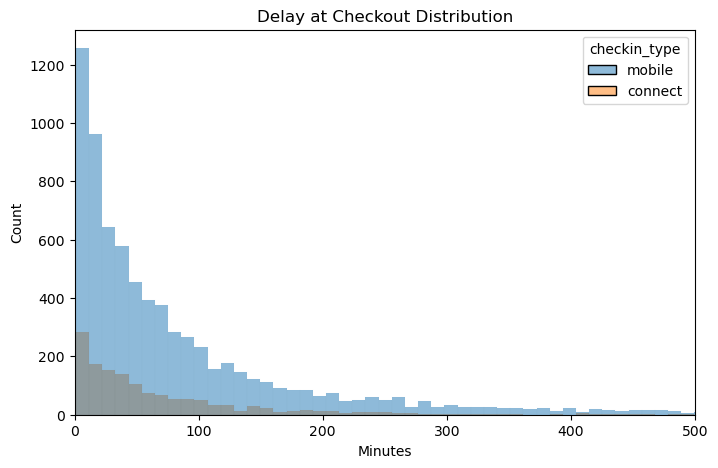

In [39]:
df_tmp = df[df["delay_at_checkout_in_minutes"]>0]
fig, ax = plt.subplots(figsize=(8,5))
# sns.histplot(df_tmp["delay_at_checkout_in_minutes"], kde=False, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4)) 
sns.histplot(data=df_tmp, x="delay_at_checkout_in_minutes", hue="checkin_type")
ax.set_title("Delay at Checkout Distribution")
ax.set_xlabel("Minutes")
# plt.xlim(600, 850)
ax.set_xlim(0, 500)
